In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle
import os
import random
from keras.preprocessing.image import ImageDataGenerator


In [7]:
###### give the path######
path="myData" #folder with all the data images
labelFile="labels.csv" #file with all names of the file

In [8]:
batch_size_val=50 #how many to process together
#steps_per_epoch_val=2000
epoch_val=10
imageDimensions=(32,32,3)
testRatio=0.2 #20% images for testing
validationRatio=0.2 #validation purpose

In [9]:
######################importing of the images
count=0
images=[]
classNo=[]
myList=os.listdir(path)
print("Total Class Detected:",len(myList))
noOfClasses=len(myList)
print("Importing classes...")
for i in range(0,len(myList)):
    myPicList=os.listdir(path+"/"+str(count))
    for y in myPicList:
        curImg=cv2.imread(path+"/"+str(count)+"/"+y)
        images.append(curImg)
        classNo.append(count)
    print(count,end=" ")
    count+=1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Class Detected: 43
Importing classes...
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


In [10]:
#####data split
X_train,X_test,y_train,y_test=train_test_split(images,classNo,test_size=testRatio)
X_train,X_validation,y_train,y_validation=train_test_split(X_train,y_train,test_size=validationRatio)

#x_train=array of images to train
#y_train=corresponding class id

In [11]:
##to check wheather the number of images matches to number of labels for each data set
print("Data shape")
print("Train",end="");print(X_train.shape,y_train.shape)
print("Validation",end="");print(X_validation.shape,y_validation.shape)
print("Test",end="");print(X_test.shape,y_test.shape)

assert(X_train.shape[0]==y_train.shape[0]), "The number of images in not equal to the number of training set"
assert(X_validation.shape[0]==y_validation.shape[0]),"not equal to the validation set"
assert(X_test.shape[0]==y_test.shape[0]), "not equal to the test set"
assert(X_train.shape[1:]==(imageDimensions)), "the dimension of train images are wrong"
assert(X_validation.shape[1:]==(imageDimensions)), "the dimension of validation images are wrong"
assert(X_test.shape[1:]==(imageDimensions)), "the dimension of test images are wrong"


Data shape
Train(22271, 32, 32, 3) (22271,)
Validation(5568, 32, 32, 3) (5568,)
Test(6960, 32, 32, 3) (6960,)


In [12]:
############################### READ CSV FILE
data=pd.read_csv(labelFile)
print("data shape ",data.shape,type(data))


data shape  (43, 2) <class 'pandas.core.frame.DataFrame'>


c:\users\acer\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  


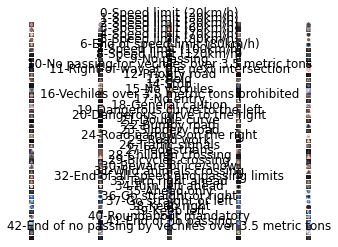

In [13]:
# DISPLAY SOME SAMPLES IMAGES  OF ALL THE CLASSES
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols)#, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j,row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)- 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j)+ "-"+row["Name"])
            num_of_samples.append(len(x_selected))

[115, 1276, 1270, 796, 1131, 1081, 221, 818, 781, 885, 1188, 749, 1219, 1209, 448, 335, 238, 624, 702, 115, 191, 170, 218, 279, 150, 864, 352, 142, 305, 150, 241, 448, 138, 381, 220, 683, 210, 114, 1158, 182, 187, 144, 143]


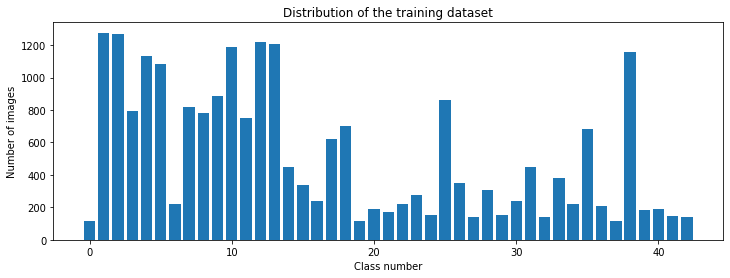

In [14]:
## DISPLAY A BAR CHART SHOWING NO OF SAMPLES FOR EACH CATEGORY
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

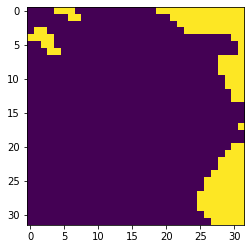

In [15]:
#PREPROCESSING THE IMAGES
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     # CONVERT TO GRAYSCALE
    img = equalize(img)      # STANDARDIZE THE LIGHTING IN AN IMAGE
    img = img/255            # TO NORMALIZE VALUES BETWEEN 0 AND 1 INSTEAD OF 0 TO 255
    img = img.astype('uint8')
    return img
X_train=np.array(list(map(preprocessing,X_train)))  # TO IRETATE AND PREPROCESS ALL IMAGES
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test)))
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.show()
cv2.imshow("GrayScale Images",X_train[random.randint(0,len(X_train)-1)]) # TO CHECK IF THE TRAINING IS DONE PROPERLY

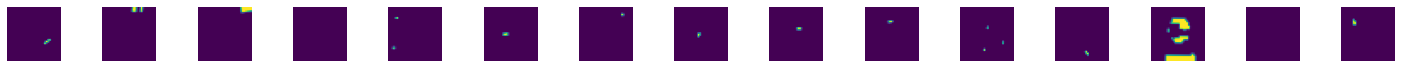

In [16]:
#ADD A DEPTH OF 1
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)


#AUGMENTATAION OF IMAGES: TO MAKEIT MORE GENERIC
dataGen= ImageDataGenerator(width_shift_range=0.1,   # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                            height_shift_range=0.1,
                            zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                            shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                            rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches= dataGen.flow(X_train,y_train,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch,y_batch = next(batches)

# TO SHOW AGMENTED IMAGE SAMPLES
fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(imageDimensions[0],imageDimensions[1]))
    axs[i].axis('off')
plt.show()


y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test,noOfClasses)


In [17]:
############################### CONVOLUTION NEURAL NETWORK MODEL
def myModel():
    no_Of_Filters=60
    size_of_Filter=(5,5) # THIS IS THE KERNEL THAT MOVE AROUND THE IMAGE TO GET THE FEATURES.
                         # THIS WOULD REMOVE 2 PIXELS FROM EACH BORDER WHEN USING 32 32 IMAGE
    size_of_Filter2=(3,3)
    size_of_pool=(2,2)  # SCALE DOWN ALL FEATURE MAP TO GERNALIZE MORE, TO REDUCE OVERFITTING
    no_Of_Nodes = 500   # NO. OF NODES IN HIDDEN LAYERS
    model= Sequential()
    model.add((Conv2D(no_Of_Filters,size_of_Filter,input_shape=(imageDimensions[0],imageDimensions[1],1),activation='relu')))  # ADDING MORE CONVOLUTION LAYERS = LESS FEATURES BUT CAN CAUSE ACCURACY TO INCREASE
    model.add((Conv2D(no_Of_Filters, size_of_Filter, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool)) # DOES NOT EFFECT THE DEPTH/NO OF FILTERS

    model.add((Conv2D(no_Of_Filters//2, size_of_Filter2,activation='relu')))
    model.add((Conv2D(no_Of_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(MaxPooling2D(pool_size=size_of_pool))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(no_Of_Nodes,activation='relu'))
    model.add(Dropout(0.5)) # INPUTS NODES TO DROP WITH EACH UPDATE 1 ALL 0 NONE
    model.add(Dense(noOfClasses,activation='softmax')) # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

In [18]:
# TRAINING THE MODEL
model = myModel()
print(model.summary())
history=model.fit_generator(dataGen.flow(X_train,y_train,batch_size=batch_size_val),epochs=epoch_val,validation_data=(X_validation,y_validation),shuffle=1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 30)          0

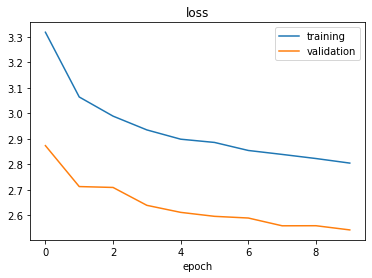

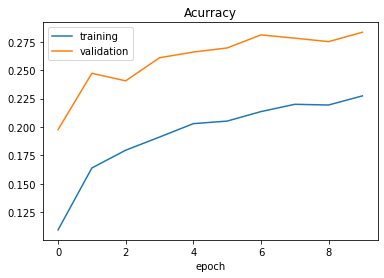

Test Score: 2.526397705078125
Test Accuracy: 0.29942527413368225


In [19]:
############################### PLOT
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

In [20]:
model.save('trained_model1.h5')